In [1]:
import tiktoken
import json
import feedparser

In [2]:
from PIL import Image
import urllib.request
from io import BytesIO

In [3]:
from IPython.display import display, HTML, Markdown

## Parse through a RSS Feed

In [4]:
podcast_feed_url = "https://access.acast.com/rss/c939f8d1-c4bc-478e-8bb9-e5343f9a7ab5" # History Hit
podcast_feed_url2 = "https://feeds.captivate.fm/tac/" # Accidental Creative
podcast_feed_url3 = "https://podcasts.files.bbci.co.uk/b036f7w2.rss" # BBC Science
podcast_feed_url4 = "https://podcastfeeds.nbcnews.com/dateline-nbc" # Dateline NBC, True Crime
podcast_feed_url5 = "https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49" # The Economist Podcast
podcast_feed = feedparser.parse(podcast_feed_url5)

In [5]:
print ("The number of podcast entries is ", len(podcast_feed.entries))

The number of podcast entries is  1196


In [6]:
type(podcast_feed)

feedparser.util.FeedParserDict

In [7]:
podcast_feed.keys()

dict_keys(['bozo', 'entries', 'feed', 'headers', 'etag', 'href', 'status', 'encoding', 'version', 'namespaces'])

In [8]:
podcast_feed.entries[99]

{'title': 'Hard pact to follow: the Good Friday Agreement at 25',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49',
  'value': 'Hard pact to follow: the Good Friday Agreement at 25'},
 'itunes_title': 'Hard pact to follow: the Good Friday Agreement at 25',
 'published': 'Tue, 11 Apr 2023 10:21:40 GMT',
 'published_parsed': time.struct_time(tm_year=2023, tm_mon=4, tm_mday=11, tm_hour=10, tm_min=21, tm_sec=40, tm_wday=1, tm_yday=101, tm_isdst=0),
 'itunes_duration': '24:25',
 'links': [{'length': '58601408',
   'type': 'audio/mpeg',
   'href': 'https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/643534b7221abd001177230f/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==&sig=ZS8r414D4u6IEz7RUMFfyAhZLIzMG2BiRhniGfwQgGU',
   'rel': 'enclosure'},
  {'rel': 'alternate',
   'type': 'text/html',
   'href': 'https://shows.acast.com/theintelligencepodcast/epi

In [9]:
podcast_feed.entries[0].links

[{'length': '47182976',
  'type': 'audio/mpeg',
  'href': 'https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/64e8767896ce15001063a3ba/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==&sig=FdVqjT7qFAlOxUqqfCG5XgbSqM1FQtMM07zGFA4tI1Y',
  'rel': 'enclosure'},
 {'rel': 'alternate',
  'type': 'text/html',
  'href': 'https://shows.acast.com/theintelligencepodcast/episodes/fellow-brics-road-a-club-expands'}]

In [10]:
tst_img = podcast_feed.entries[200].image.href

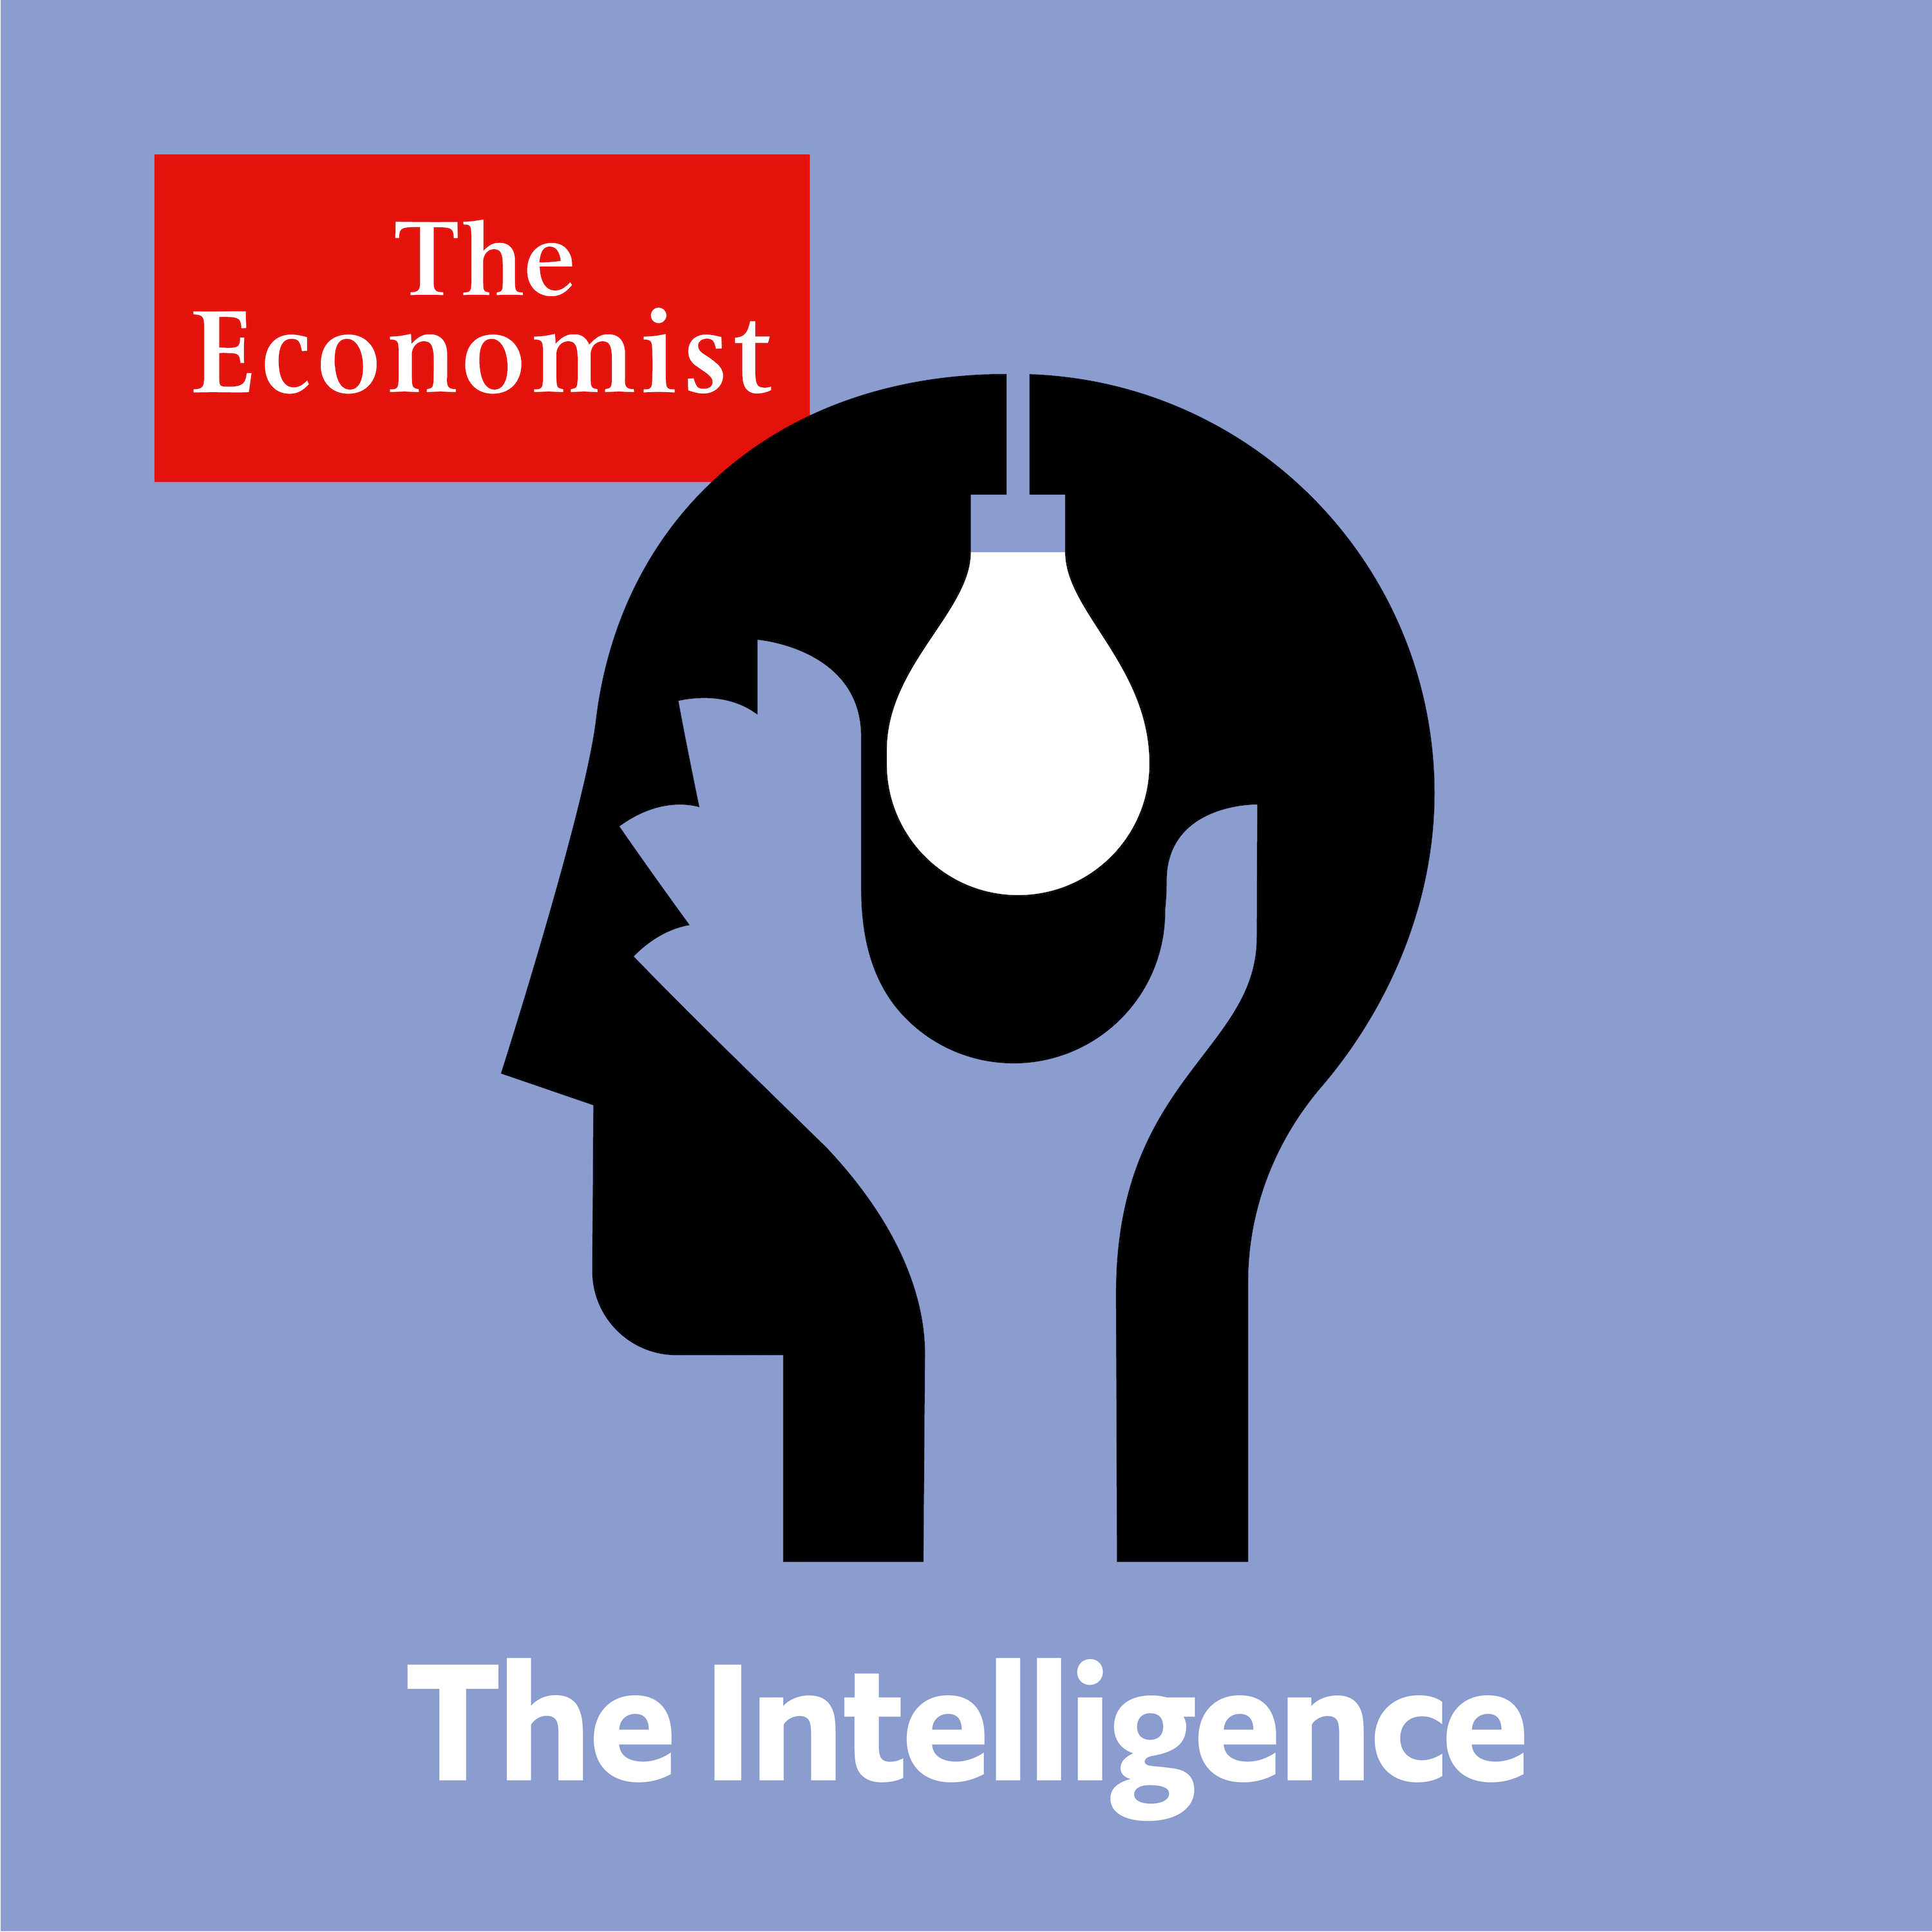

In [11]:
url = tst_img
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

## Functions to Normalise the Podcasts Data from RSS Feeds

In [12]:
import re

def parse_duration(duration_str):
    try:
        pattern = re.compile(r'^((\d+):)?(\d+):(\d+)$|^(\d+)$')
        match = pattern.match(duration_str)

        if match:
            if match.group(5):
                seconds = int(match.group(5))
                minutes = seconds // 60
                hours = 0
                if minutes >= 60:
                    hours = minutes // 60
                    minutes = minutes % 60
                seconds %= 60
                return hours, minutes, seconds
            else:
                hours = int(match.group(2)) if match.group(2) else 0
                minutes = int(match.group(3))
                seconds = int(match.group(4))
                return hours, minutes, seconds
        else:
            print("Format Invalid, Returning Default of 30 minutes")
            return 0, 30, 0
    except Exception as e:
        print(f"Error in finding duration: {e}")
        print("Error, Returning Default of 30 minutes")
        return 0, 30, 0

# Test cases
duration_strings = [
    '00:39:01',
    '00:40:31',
    '39:43',
    '59:28',
    '1970',
    '1730',
    '01:18:10',
    '10:39:54',
    '25:04',
    '24:46',
    '2345',
    '1:1:1'
]

for duration_str in duration_strings:
    hours, minutes, seconds = parse_duration(duration_str)
    print(f"Input: {duration_str} => Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}")


Input: 00:39:01 => Hours: 0, Minutes: 39, Seconds: 1
Input: 00:40:31 => Hours: 0, Minutes: 40, Seconds: 31
Input: 39:43 => Hours: 0, Minutes: 39, Seconds: 43
Input: 59:28 => Hours: 0, Minutes: 59, Seconds: 28
Input: 1970 => Hours: 0, Minutes: 32, Seconds: 50
Input: 1730 => Hours: 0, Minutes: 28, Seconds: 50
Input: 01:18:10 => Hours: 1, Minutes: 18, Seconds: 10
Input: 10:39:54 => Hours: 10, Minutes: 39, Seconds: 54
Input: 25:04 => Hours: 0, Minutes: 25, Seconds: 4
Input: 24:46 => Hours: 0, Minutes: 24, Seconds: 46
Input: 2345 => Hours: 0, Minutes: 39, Seconds: 5
Input: 1:1:1 => Hours: 1, Minutes: 1, Seconds: 1


In [13]:
from bs4 import BeautifulSoup
from bs4.element import Comment

def extract_text_from_html_or_return_as_is(input_str):
    try:
        soup = BeautifulSoup(input_str, 'html.parser')
        
        def visible(element):
            if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
                return False
            if isinstance(element, Comment):
                return False
            return True
        
        text_parts = filter(visible, soup.find_all(text=True))
        extracted_text = " ".join(text.strip() for text in text_parts)
        
        if extracted_text:
            return extracted_text
        else:
            return input_str
    except:
        return input_str

# Test cases
html_string = "<html><body><h1>Hello, World!</h1><p>This is a test.</p></body></html>"
non_html_string = "This is a plain text string."

result_html = extract_text_from_html_or_return_as_is(html_string)
result_non_html = extract_text_from_html_or_return_as_is(non_html_string)

print("Input HTML String:", result_html)
print("Input Non-HTML String:", result_non_html)


Input HTML String: Hello, World! This is a test.
Input Non-HTML String: This is a plain text string.


In [14]:
tst_html = """
<p>On his visit to Beijing Emmanuel Macron, France’s president, has much to balance: his peacemaking ways, a more hawkish travel partner and the commercial interests of his delegation of business leaders. What will result? We ask what is being done to avoid a <a href="https://www.economist.com/asia/2023/03/21/north-koreans-are-at-growing-risk-of-starvation?utm_campaign=a.io&amp;utm_medium=audio.podcast.np&amp;utm_source=theintelligence&amp;utm_content=discovery.content.anonymous.tr_shownotes_na-na_article&amp;utm_term=sa.listeners" rel="noopener noreferrer" target="_blank">looming famine</a> in North Korea. And why baseball is getting <a href="https://www.economist.com/culture/2023/03/24/major-league-baseball-sheds-its-conservatism-and-embraces-fun?utm_campaign=a.io&amp;utm_medium=audio.podcast.np&amp;utm_source=theintelligence&amp;utm_content=discovery.content.anonymous.tr_shownotes_na-na_article&amp;utm_term=sa.listeners" rel="noopener noreferrer" target="_blank">speedier and more action-packed</a> this season.&nbsp;</p><p>For full access to print, digital and audio editions of <em>The Economist</em>, try a free 30-day digital subscription by going to <a href="http://www.economist.com/intelligenceoffer" rel="noopener noreferrer" target="_blank">www.economist.com/intelligenceoffer</a></p><br /><hr /><p style="color: grey; font-size: 0.75em;"> Hosted on Acast. See <a href="https://acast.com/privacy" rel="noopener noreferrer" style="color: grey;" target="_blank">acast.com/privacy</a> for more information.</p>
"""

In [15]:
HTML(tst_html)

In [16]:
extract_text_from_html_or_return_as_is(tst_html)

'On his visit to Beijing Emmanuel Macron, France’s president, has much to balance: his peacemaking ways, a more hawkish travel partner and the commercial interests of his delegation of business leaders. What will result? We ask what is being done to avoid a looming famine in North Korea. And why baseball is getting speedier and more action-packed this season. For full access to print, digital and audio editions of The Economist , try a free 30-day digital subscription by going to www.economist.com/intelligenceoffer Hosted on Acast. See acast.com/privacy for more information.'

In [17]:
extract_text_from_html_or_return_as_is("'Years after a love triangle involving trucking magnate Bill Hall Jr. ends in a deadly car chase, insiders speak out about the latest twist in the story. Andrea Canning reports.'")

"'Years after a love triangle involving trucking magnate Bill Hall Jr. ends in a deadly car chase, insiders speak out about the latest twist in the story. Andrea Canning reports.'"

In [18]:
from dateutil import parser
from datetime import datetime

def format_date(input_date_string):
    try:
        parsed_date = parser.parse(input_date_string)
        formatted_date = parsed_date.strftime('%d/%m/%Y')
        return formatted_date
    except Exception as e:
        print(f"Error in parsing the published date: {e}")
        print("Returning a standard date of 1st July 2023")
        return "01/07/2023"

# Test cases
input_strings = [
    'Thu, 17 Aug 2023 04:00:00 -0400',
    'Mon, 14 Aug 2023 04:00:00 -0400',
    'Tue, 07 Mar 2023 00:30:59 GMT',
    'Thu, 17 Aug 2023 16:00:00 +0000',
    'Tue, 15 Aug 2023 10:00:00 +0000',
    'Fri, 18 Aug 2023 10:07:04 GMT',
    'Wed, 16 Aug 2023 10:28:47 GMT',
    'Thu, 10 Aug 2023 08:00:00 -0400',
    "1/1/23"
]

for input_str in input_strings:
    formatted_date = format_date(input_str)
    print(f"Input: {input_str} => Formatted Date: {formatted_date}")


Input: Thu, 17 Aug 2023 04:00:00 -0400 => Formatted Date: 17/08/2023
Input: Mon, 14 Aug 2023 04:00:00 -0400 => Formatted Date: 14/08/2023
Input: Tue, 07 Mar 2023 00:30:59 GMT => Formatted Date: 07/03/2023
Input: Thu, 17 Aug 2023 16:00:00 +0000 => Formatted Date: 17/08/2023
Input: Tue, 15 Aug 2023 10:00:00 +0000 => Formatted Date: 15/08/2023
Input: Fri, 18 Aug 2023 10:07:04 GMT => Formatted Date: 18/08/2023
Input: Wed, 16 Aug 2023 10:28:47 GMT => Formatted Date: 16/08/2023
Input: Thu, 10 Aug 2023 08:00:00 -0400 => Formatted Date: 10/08/2023
Input: 1/1/23 => Formatted Date: 01/01/2023


## Function to take some RSS Feed URLs and Get Data Ready for Streamlit App

### Input the URLs in a dict: {"Podcast Name": RSS Feed Link}
### For now, we take the last 100 episodes which are less than or equal to 45 minutes in duration
### Data to be taken from each episode :

- Title (Must)
- Summary (Have both HTML & Text) (Must)
- Image (If available)
- Duration (Must)
- Date Published (Must)
- MP3 Audio Link (Must)

### Data to be used for Embedding: Concatenation of Title & Summary (Future Scope)
### Data to be used to send to GPT for Recommendation: Title, Summary, Duration
### Data used for Filtering in Streamlit: Duration & Date Published
### Data to be used for Summarising the Podcast: MP3 Audio Link (If using Quick Listen Function)

In [19]:
def prepare_podcast_data(RSS_Feed_URLs_Dict):
    
    Podcasts_Dict = {}
    for podcast_name, rss_url in RSS_Feed_URLs_Dict.items():
        Podcasts_Dict[podcast_name] = [] #Storing Episode Dictionaries
        podcast_feed = feedparser.parse(rss_url)
        
        for episode in podcast_feed.entries:
            
            # Check if 100 episodes are selected from Podcast 
            
            if len(Podcasts_Dict[podcast_name]) < 100:
            
                # Check that necessary Episode Data is present
                if 'itunes_duration' in episode and 'title' in episode and 'summary' in episode and 'published' in episode and 'links' in episode:
                    # Check MP3 Audio Link Present
                    episode_mp3_link = None
                    for link_data in episode['links']:
                        if link_data['type'] == 'audio/mpeg':
                            episode_mp3_link = link_data.get('href')
                    if episode_mp3_link: # If we found Episode MP3 Link
                        episode_duration = parse_duration(episode.get('itunes_duration')) # Setting Default to 30 mins
                        episode_duration_seconds = (episode_duration[0]*60*60 + episode_duration[1]*60 + episode_duration[2]) #converting into seconds to check
                        if episode_duration_seconds <= (45*60): # If Podcast Duration is less than equal to 45 mins
                            # Get Summary & Title
                            episode_title = episode['title']
                            episode_summary = extract_text_from_html_or_return_as_is(episode['summary'])
                            # Get Date Published
                            episode_date = format_date(episode['published'])

                            # If Image Available have it
                            try:
                                episode_image_link = episode.get("image").get("href")
                            except Exception as e:
                                print("No Image Link Available")
                                episode_image_link = ""

                            # Final Checks: Title, Summary & MP3 must be non-empty strings
                            if type(episode_title)==str and type(episode_summary)==str and type(episode_mp3_link)==str:
                                if episode_title.strip() and episode_summary.strip() and episode_mp3_link.strip():
                                    episode_data = {"Title": episode_title, 
                                                    "Summary":  episode_summary, 
                                                    "MP3": episode_mp3_link,
                                                    "Duration": episode_duration,
                                                    "Date":  episode_date}
                                    # If Image Available add it
                                    if type(episode_image_link)==str:
                                        if episode_image_link.strip():
                                            episode_data["Image"] = episode_image_link
                                    # If all above checks are passed we add it in the Podcast List
                                    Podcasts_Dict[podcast_name].append(episode_data)

    return Podcasts_Dict                                    

## Feel Free to Add in your RSS Feeds Here

### You can add a feature in your Streamlit App to take in a new feed, Prepare it, and write to the CSV

In [20]:
podcast_feed_url = "https://access.acast.com/rss/c939f8d1-c4bc-478e-8bb9-e5343f9a7ab5" # History Hit
podcast_feed_url2 = "https://feeds.captivate.fm/tac/" # Accidental Creative
podcast_feed_url3 = "https://podcasts.files.bbci.co.uk/b036f7w2.rss" # BBC Science
podcast_feed_url4 = "https://podcastfeeds.nbcnews.com/dateline-nbc" # Dateline NBC, True Crime
podcast_feed_url5 = "https://access.acast.com/rss/d556eb54-6160-4c85-95f4-47d9f5216c49" # The Economist Podcast

In [21]:
Podcasts_Input = {"History Hit": podcast_feed_url, 
                  "Accidental Creative": podcast_feed_url2,
                  "BBC Science": podcast_feed_url3,
                  "Dateline NBC (True Crime)": podcast_feed_url4,
                  "The Economist": podcast_feed_url5}

In [22]:
Final_Podcast_Data = prepare_podcast_data(Podcasts_Input)

No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Available
No Image Link Av

/Users/arazsharma/opt/anaconda3/envs/LeenaQA/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
Final_Podcast_Data.keys()

dict_keys(['History Hit', 'Accidental Creative', 'BBC Science', 'Dateline NBC (True Crime)', 'The Economist'])

In [24]:
Final_Podcast_Data['The Economist'][10]

{'Title': 'In the big leagues now: Saudi Arabia’s push into sport',
 'Summary': 'Crown Prince Muhammad bin Salman says a presence in top-level global sport is one route to modernising; critics call the effort a distraction from the country’s appalling human-rights record. Brazil’s government is pushing reforms that are clearly calming investors , who had fretted about a return to ruinously spendthrift policies (9:20). And how speedy “first-person-view” drones are changing the fight in Ukraine (16:25). For full access to print, digital and audio editions of The Economist , try a free 30-day digital subscription by going to www.economist.com/intelligenceoffer Hosted on Acast. See acast.com/privacy for more information.',
 'MP3': 'https://sphinx.acast.com/p/acast/s/theintelligencepodcast/e/64d60854cbaac50011d7aea5/media.mp3?tk=eyJ0ayI6ImRlZmF1bHQiLCJhZHMiOnRydWUsInNwb25zIjp0cnVlLCJzdGF0dXMiOiJwdWJsaWMifQ==&sig=O93Lcs3oMwbt7uHiYyvDHy9xcb2OzN1gdZAKki5yoEs',
 'Duration': (0, 24, 44),
 'Date'

In [25]:
for podcast_name, episodes in Final_Podcast_Data.items():
    print(podcast_name, len(episodes))

History Hit 100
Accidental Creative 100
BBC Science 100
Dateline NBC (True Crime) 100
The Economist 100


In [26]:
import pandas as pd

In [27]:
df_structure = {
    'Podcast Name': [],
    'Episode Title': [],
    'Episode Summary': [],
    'Episode Duration': [],
    'Episode Date': [],
    'Podcast Image': [],
    'Episode Audio': [],
    'Episode Guests': [],
    'Episode Highlights': [],
}

In [28]:
for podcast_name, episodes in Final_Podcast_Data.items():
    for episode in episodes:
        df_structure['Podcast Name'].append(podcast_name)
        df_structure['Episode Title'].append(episode['Title'])
        df_structure['Episode Summary'].append(episode['Summary'])
        df_structure['Episode Duration'].append(int(episode['Duration'][1]))
        df_structure['Episode Date'].append(episode['Date'])
        df_structure['Podcast Image'].append(episode.get('Image', ""))
        df_structure['Episode Audio'].append(episode['MP3'])
        df_structure['Episode Guests'].append([])
        df_structure['Episode Highlights'].append([])
        

In [29]:
Podcasts_DF = pd.DataFrame(df_structure)

In [30]:
Podcasts_DF

,Podcast Name,Episode Title,Episode Summary,Episode Duration,Episode Date,Podcast Image,Episode Audio,Episode Guests,Episode Highlights
0,History Hit,Chairman Mao,Leader of the Chinese Communist Party from 194...,43,22/08/2023,https://assets.pippa.io/shows/6215f67d4b795a40...,https://sphinx.acast.com/p/acast/s/dansnowshis...,[],[]
1,History Hit,Elizabeth I's War with Ireland,"Queen Elizabeth I, Gloriana, victor over the S...",37,21/08/2023,https://assets.pippa.io/shows/6215f67d4b795a40...,https://sphinx.acast.com/p/acast/s/dansnowshis...,[],[]
2,History Hit,The Ancient Greek Computer: The Antikythera Me...,In the recent Indiana Jones: The Dial of Desti...,28,20/08/2023,https://assets.pippa.io/shows/6215f67d4b795a40...,https://sphinx.acast.com/p/acast/s/dansnowshis...,[],[]
3,History Hit,Battle of Gettysburg,The first three days of July 1863 saw the bloo...,39,16/08/2023,https://assets.pippa.io/shows/6215f67d4b795a40...,https://sphinx.acast.com/p/acast/s/dansnowshis...,[],[]
4,History Hit,The Rise of the Taliban,Is it possible that the Taliban of today are m...,25,15/08/2023,https://assets.pippa.io/shows/6215f67d4b795a40...,https://sphinx.acast.com/p/acast/s/dansnowshis...,[],[]
...,...,...,...,...,...,...,...,...,...
495,The Economist,Never-ending storeys: rebuilding Turkey,It will be years until the country recovers fr...,25,14/04/2023,https://assets.pippa.io/shows/62e286a934d4d93d...,https://sphinx.acast.com/p/acast/s/theintellig...,[],[]
496,The Economist,Make the world’s money go ‘round: a bunged-up IMF,The International Monetary Fund is sitting on ...,25,13/04/2023,https://assets.pippa.io/shows/62e286a934d4d93d...,https://sphinx.acast.com/p/acast/s/theintellig...,[],[]
497,The Economist,File-sharing: America’s huge intelligence leak,A trove of once-secret documents is proving an...,24,12/04/2023,https://assets.pippa.io/shows/62e286a934d4d93d...,https://sphinx.acast.com/p/acast/s/theintellig...,[],[]
498,The Economist,Hard pact to follow: the Good Friday Agreement...,The famed power-sharing deal did its work of s...,24,11/04/2023,https://assets.pippa.io/shows/62e286a934d4d93d...,https://sphinx.acast.com/p/acast/s/theintellig...,[],[]


## Write to the File you want to use for your Streamlit App

In [ ]:
csv_filename = 'Podcasts_Data.csv'
Podcasts_DF.to_csv(csv_filename, index=False)